# Desafío - Análisis lineal discriminante.
### Nombre: Thomas Peet, Braulio Aguila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 29-08-2022

## Requerimientos  
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se
registran las siguientes observaciones:
- `default`: Variable Binaria. Registra si el cliente entró en morosidad o no.
- `income` : Ingreso promedio declarado por el cliente.
- `balance`: total del saldo en la cuenta de crédito.
- `student`: Variable binaria. Registra si el cliente es estudiante o no.

### Ejercicio 1: Preparación de ambiente de trabajo
- Importe los módulos básicos para el análisis de datos.
- Importe las clases LabelEncoder, StandardScaler y LabelBinarizer de
preprocessing.
- Importe las funciones train_test_split y cross_val_score de
model_selection.
- Importe la función classification_report de metrics.
- Importe las clases LinearDiscriminantAnalysis y
QuadraticDiscriminantAnalysis.
- Agregue la base de datos en el ambiente de trabajo.
- Inspeccione la distribución de cada atributo.

In [25]:
# Modulo básicos de datascience
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-procesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from feature_engine.wrappers import SklearnTransformerWrapper

# Modelamiento
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Métricas
from sklearn.metrics import classification_report

# Otros
from IPython.display import HTML

>>### Comentario
El problema que abordaremos en este desafío consiste en entrenar un modelo que permita clasificar a un cliente como posible moroso utilizando la información de las variables del ingreso, etapa de estudio y total del saldo en la cuenta.



In [26]:
df = pd.read_csv('default_credit.csv', index_col = 0)
df.head()

,default,student,balance,income
index,,,,
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [27]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


>>### Comentario
Al observar la base de datos notamos la siguiente
- La base cuenta con 10000 muestras
- No encontramos datos nulos
- Presenta 2 variables categóricas (1 siendo la variable target) y 2 variables numéricas.

### Ejercicio 2: Modelo base
- Recuerde que los modelos de sklearn no soportan datos que no sean numéricos.
Transforme los atributos pertinentes con LabelEncoder.
- Genere muestras de validación y entrenamiento, reservando un 33% de los datos
como validación.
- Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiper
parámetros. Genere métricas de evaluación utilizando classification_report.
- Comente sobre cuál es el desempeño del modelo en cada clase, así como en
general.

In [29]:
# Encodeo de variables categóricas
LE = LabelEncoder()
df.default = LE.fit_transform(df.default)
df.student = LE.fit_transform(df.student)

# Estandarización de variables numéricas
SC = SklearnTransformerWrapper(StandardScaler(), variables = ["income","balance"])
df = SC.fit_transform(df)

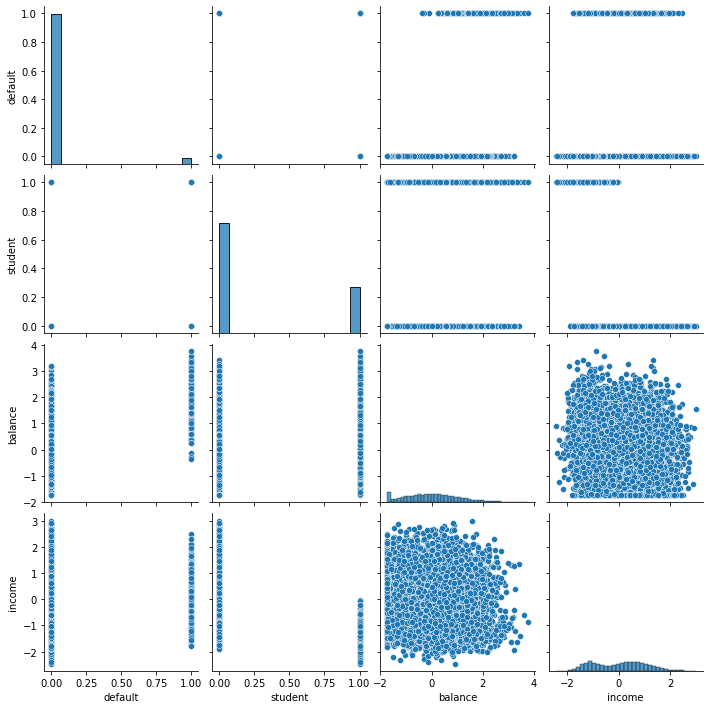

In [30]:
# Estos gráficos nos ayudan a visualizar las distribuciones de las variables.
sns.pairplot(df)

>>### Comentario
El gráfico `pairplot` nos muestra que la variable `default` presenta un claro desbalanceo de clases. La clase 1 contiene aproximadamente un 97% del total de la muestra. 

La variable `student` también presenta un cierto grado de desbalanceo hacia la clase 1, pero bastante menor (aproximadamente una relación de 70-30%)

A priori, podemos suponer que tendremos mucha menos información para comprender al cliente moroso que al cliente no moroso. Esto se conoce como un problema de `desbalanceo de clases`.

In [31]:
y = df.default
X = df.drop(columns = 'default')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11238)

# Modelo LinearDiscriminantAnalysis sin hiperparámetros
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print('Performance sobre data entrenamiento')
print(classification_report(y_train, lda.predict(X_train), digits = 4))

print('Performance sobre data validación')
print(classification_report(y_test,y_pred, digits = 4))

Performance sobre data entrenamiento
              precision    recall  f1-score   support

           0     0.9745    0.9981    0.9862      6481
           1     0.8065    0.2283    0.3559       219

    accuracy                         0.9730      6700
   macro avg     0.8905    0.6132    0.6710      6700
weighted avg     0.9690    0.9730    0.9656      6700

Performance sobre data validación
              precision    recall  f1-score   support

           0     0.9739    0.9965    0.9851      3186
           1     0.7250    0.2544    0.3766       114

    accuracy                         0.9709      3300
   macro avg     0.8495    0.6255    0.6809      3300
weighted avg     0.9653    0.9709    0.9641      3300



>>### Comentario
El modelo tiene un buen desempeño a nivel general ya que alcanza un $97.09%$ de accuracy. Sin embargo, esto se debe a lo que se mencionó anteriormente respecto del desbalanceo de clases. Dado que el 97% de datos del set corresponden a casos de no morosidad, claramente, está clase fue correctamente aprendida por el modelo. No obstante, esto no asegura que la clase  morosidad sea correctamente clasificada por este modelo. Justamente, es la clase 1 la que más nos interesa poder predecir, ya que es la que nos indicará si un cliente será moroso o no.

Lo que nos interesa corregir, son los siguientes casos:
- Los casos que el modelo predice como morosos pero que en realidad no lo son (Falso Positivo)
- Los casos que el modelo predice como no morosos y que en realidad si lo son (Falso Negativo)

Para poder medir la efectividad de nuestro modelo en este problema se deben utilizar métricas orientadas a la detección de Falsos negativos y Falsos positivos.

La métrica `recall` nos sirve para detectar la proporción de FN en relación a VP.

La métrica `precision` nos sirve para detectar la proporción entre los FP y los VP.

Utilizaremos ambas métricas para evaluar el desempeño de los modelos que entrenaremos en este desafío.

### Ejercicio 3: Refactorización 1 - información a priori
- Dado que trabajamos con modelos generativos, podemos incluir información
exógena. Para este caso agregaremos dos distribuciones:  
    - Asumamos que hay un 50/50 de morosos y no morosos.  
    - Asumamos que hay un 60/40 de morosos y no morosos.  
- Por cada modelo, reporte las métricas de clasificación.

In [32]:
# Se definen los hiperpárametros (priors) de los modelos a entrenar
priors_dict = {
    'no prior': None,
    'prior dist 50% 50%': [0.5, 0.5],
    'prior dist 40% 60%': [0.4, 0.6]
}

# Los modelos entrenados serán almacenados en un diccionario para poder compararlos posteriormente.
lda = {}

# Se entrenan los modelos y se muestran las métricas asociadas.
for key,val in priors_dict.items():
    print(key)
    lda[key] = LinearDiscriminantAnalysis(priors = val)
    lda[key].fit(X_train, y_train)
    y_pred = lda[key].predict(X_test)
    print(classification_report(y_test,y_pred, digits = 4))

no prior
              precision    recall  f1-score   support

           0     0.9739    0.9965    0.9851      3186
           1     0.7250    0.2544    0.3766       114

    accuracy                         0.9709      3300
   macro avg     0.8495    0.6255    0.6809      3300
weighted avg     0.9653    0.9709    0.9641      3300

prior dist 50% 50%
              precision    recall  f1-score   support

           0     0.9966    0.8387    0.9109      3186
           1     0.1696    0.9211    0.2865       114

    accuracy                         0.8415      3300
   macro avg     0.5831    0.8799    0.5987      3300
weighted avg     0.9681    0.8415    0.8893      3300

prior dist 40% 60%
              precision    recall  f1-score   support

           0     0.9980    0.7866    0.8798      3186
           1     0.1381    0.9561    0.2414       114

    accuracy                         0.7924      3300
   macro avg     0.5681    0.8714    0.5606      3300
weighted avg     0.9683    

### Ejercicio 4: Refactorización 2 - oversampling
#### Digresión: Synthetic Over(Under)Sampling
- Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
- Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
- Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la clase minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante $x$ es un ejemplo de $x_{nuevo-ejemplo} = x_i + \lambda(x_{zi} − x_i)$ entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim Uniforme(0, 1).$
- Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn`. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`. 
- Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintaxis:

```python
        from imblearn.over_sampling import SMOTE
        # Instanciamos la clase
        oversampler = SMOTE(random_state=11238, ratio='minority')
        # generamos el eversampling de la matriz de entrenamiento y
        X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

- Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [33]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
# oversampler = SMOTE(random_state=11238, ratio='minority')
oversampler = SMOTE(sampling_strategy='auto', random_state=11238)
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train,y_train)

In [34]:
# Nueva distribución de la variable target
y_train_oversamp.value_counts()

0    6481
1    6481
Name: default, dtype: int64

In [35]:
priors_dict_os = {
    'no prior': None,
    'prior dist 50% 50%': [0.5, 0.5],
    'prior dist 40% 60%': [0.4, 0.6]
}
lda_os = {}
for key, val in priors_dict_os.items():
    print(key)
    lda_os[key] = LinearDiscriminantAnalysis(priors = val)
    lda_os[key].fit(X_train_oversamp, y_train_oversamp)
    y_pred = lda_os[key].predict(X_test)
    print(classification_report(y_test,y_pred, digits = 4))


no prior
              precision    recall  f1-score   support

           0     0.9966    0.8399    0.9116      3186
           1     0.1707    0.9211    0.2881       114

    accuracy                         0.8427      3300
   macro avg     0.5837    0.8805    0.5998      3300
weighted avg     0.9681    0.8427    0.8901      3300

prior dist 50% 50%
              precision    recall  f1-score   support

           0     0.9966    0.8399    0.9116      3186
           1     0.1707    0.9211    0.2881       114

    accuracy                         0.8427      3300
   macro avg     0.5837    0.8805    0.5998      3300
weighted avg     0.9681    0.8427    0.8901      3300

prior dist 40% 60%
              precision    recall  f1-score   support

           0     0.9977    0.7997    0.8878      3186
           1     0.1448    0.9474    0.2512       114

    accuracy                         0.8048      3300
   macro avg     0.5712    0.8736    0.5695      3300
weighted avg     0.9682    

>>### Comentarios
- Notamos que el primer y segundo modelo, en este caso oversampleado, pasan a ser el mismo modelo, ya que al agregar datos sintéticos, se equiparan la cantidad de datos de cada clase a 50-50%. El proveer un prior de 50-50% no tiene efecto ya que eso ahora se obtiene desde los datos.
- Dada la naturaleza del problema, estamos más interesados en obtener un mayor recall que una mejor precision. Esto se debe a que tiene más importancia identificar correctamente a los morosos que sí lo son (recall) en comparación a identificar incorrectamente un no moroso como moroso (precision). Probablemente para un banco o institución financiera, es de mayor relevancia, conocer quienes son los clientes potencialmente morosos e buscar que paguen sus deudas en comparación al problema que significa molestar a clientes no morosos como si lo fueran.
- En relación al punto anterior, observamos que al introducir datos sintéticos con SMOTE, se fortalece el desempeño del modelo en el terreno que efectivamente nos interesa privilegiar (recall). Si comparamos el caso `no-prior` y `sin-smote` con el caso `no-prior` y `con-smote`, observamos un `trade-off` entre precision y recall. 

    ||no-prior & no-smote| no-prior & si-smote|  
    |--| --- | --- |   
    |recall|$0.2544$|$0.9211$|   
    |precision|$0.7250$|$0.1707$|  
    
- Esto es es justamente lo que está buscando porque preferimos asegurarnos de detectar a los morosos aún cuando eso signifique marcar como morosa a clientes que no lo son.


### Ejercicio 5: Refactorización 3 - QDA
- Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.  
- Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.  

In [36]:
qda_os = QuadraticDiscriminantAnalysis()
qda_os.fit(X_train_oversamp, y_train_oversamp)
y_pred = qda_os.predict(X_test)
print(classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9963    0.8540    0.9197      3186
           1     0.1828    0.9123    0.3045       114

    accuracy                         0.8561      3300
   macro avg     0.5896    0.8832    0.6121      3300
weighted avg     0.9682    0.8561    0.8985      3300



In [37]:
import json
models = {
    'lda_np': lda['no prior'],                          # Linear Discriminant Analysis No Prioir
    'lda_pr_5050': lda['prior dist 50% 50%'] ,          # Linear Discriminant Analysis Prior 50%-50%
    'lda_pr_4060': lda['prior dist 40% 60%'],           # Linear Discriminant Analysis Prior 40%-60%
    'lda_np_os': lda_os['no prior'] ,                   # Linear Discriminant Analysis No Prioir - Oversampled SMOTE
    'lda_pr_5050_os': lda_os['prior dist 50% 50%'] ,    # Linear Discriminant Analysis Prior 50%-50% - Oversampled SMOTE
    'lda_pr_4060_os': lda_os['prior dist 40% 60%'] ,    # Linear Discriminant Analysis Prior 40%-60% - Oversampled SMOTE
    'qda_os': qda_os                                    # Quadratic Discriminant Analysis - Oversampled SMOTE
}

# Creamos un diccionario con las metricas de cada modelo
cr = {}
for key,val in models.items():
    cr[key] = classification_report(y_test, val.predict(X_test),digits = 4, output_dict = True)

# Ordenar un poco el diccionario creado
for tag, model_metrics in cr.items():
    model_metrics_copy = model_metrics.copy()
    for metrics, values in model_metrics_copy.items():
        if metrics in ['0', '1', 'macro avg', 'weighted avg']:
            aux_dict = cr[tag][metrics].copy()
            for k,v in aux_dict.items():
                oldvalue = cr[tag][metrics]
                cr[tag][k + '_subtype_' + metrics] = cr[tag][metrics].pop(k)
                if 'support' in k or 'f1-score' in k:
                    del cr[tag][k + '_subtype_' + metrics]
            del cr[tag][metrics]
    cr[tag] = {key: value for key, value in sorted(cr[tag].items())}

# Se crea una tabla a partir del diccionario de metricas por modelo
table_str = '<table><tr><th>Models</th><th>' + '</th><th>'.join(models.keys()) + '</th></tr>'
metrics = list(cr[next(iter(cr))].keys())
models_tags = cr.keys()
for metric in metrics:
    table_str += '<tr>'
    table_str += f"<td>{metric}</td>"
    max_value = max([cr[model][metric] for model in models_tags])
    min_value = min([cr[model][metric] for model in models_tags])
    for model in models_tags:
        table_str += f"<td>{cr[model][metric]:.4f}</td>"
    table_str += '</tr>'
display(HTML(table_str))

Models,lda_np,lda_pr_5050,lda_pr_4060,lda_np_os,lda_pr_5050_os,lda_pr_4060_os,qda_os
accuracy,0.9709,0.8415,0.7924,0.8427,0.8427,0.8048,0.8561
precision_subtype_0,0.9739,0.9966,0.9980,0.9966,0.9966,0.9977,0.9963
precision_subtype_1,0.7250,0.1696,0.1381,0.1707,0.1707,0.1448,0.1828
precision_subtype_macro avg,0.8495,0.5831,0.5681,0.5837,0.5837,0.5712,0.5896
precision_subtype_weighted avg,0.9653,0.9681,0.9683,0.9681,0.9681,0.9682,0.9682
recall_subtype_0,0.9965,0.8387,0.7866,0.8399,0.8399,0.7997,0.8540
recall_subtype_1,0.2544,0.9211,0.9561,0.9211,0.9211,0.9474,0.9123
recall_subtype_macro avg,0.6255,0.8799,0.8714,0.8805,0.8805,0.8736,0.8832
recall_subtype_weighted avg,0.9709,0.8415,0.7924,0.8427,0.8427,0.8048,0.8561


>>### Comentarios
- Podemos observar que el modelo de mayor `accuracy` es el modelo más simple. Como ya indicamos anteriormente esto se debe a que este modelo predice con gran efectividad los casos de clase 0 (no morosos) pero tiene mas dificultades para detectar clientes morosos.
- Observamos que los modelos en que se incluyo información a priori tuvieron una mejora sustantiva en el valor de `recall` (tanto el modelo 50-50 como el 40-60). Sin embargo esto fue en desmedro del `accuracy` y la `precision`.
- Por otro lado el hecho de incluir `oversampling` mediante SMOTE, si bien mejoro sustantivamente el `recall` lo hizo en menor medida. No obstante la baja en `precision` y `accuracy` fue menor que introduciendo información a priori.
- Al incluir ambas modificaciones en el modelo se logra un rendimiento más estable entre `accuracy`, `precision` (en menor medida) y `recall` como se puede observar en los modelos `lda_pr_5050_os` y `lda_pr_4060_os`.
- Por último, tenemos que el modelo `Quadratic Discriminant Analysis` con Oversampling es el que da mayor estabilidad, no tan solo en las métricas anteriormente mencionadas, sino que también incluyendo las métricas de la clase de menor interés (clase 0).